# This document is proof-of-work for a datascience competition I recently participated in.

In [1]:
import time
import numpy as np
from copy import copy, deepcopy

# First of all we import the Flatland rail environment
from rail_env import RailEnv
from observations import TreeObsForRailEnvAug, feat_order, feat_vec_max

from flatland.envs.rail_generators import sparse_rail_generator
from flatland.envs.schedule_generators import sparse_schedule_generator
# We also include a renderer because we want to visualize what is going on in the environment
from flatland.utils.rendertools import RenderTool, AgentRenderVariant
from flatland.envs.malfunction_generators import malfunction_from_params
from flatland.envs.agent_utils import RailAgentStatus

from collections import defaultdict

from scipy.ndimage import rotate
from scipy.sparse.csr import csr_matrix
# from scipy.sparse import coo_matrix
import scipy.sparse as sp
from scipy.sparse.csgraph import connected_components
from scipy.signal import lfilter 

from gcn import GCN, args
from multihead_attention import MultiHeadAttention
from rl_models import Value

import networkx as nx

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
%matplotlib inline

import torch
device = torch.device('cuda')

### Utilities

In [2]:

def scale(a, m, M):
    return (a-m)/(M-m)

def rotate_map(maps, dir_):
    rot_deg = (dir_-4)*90
    if rot_deg == -360: rot_deg = 0
    if rot_deg != 0:
        maps = rotate(maps, rot_deg)
    return maps

def get_rotation_dict():
    xx, yy = np.meshgrid(np.arange(2*RAD+1), np.arange(2*RAD+1))
    idx_mat = yy*(2*RAD+1) + xx
    rotation_dict = dict()
    for dir_ in range(0, 4):
        rotation_dict[dir_] = rotate_map(idx_mat, dir_).ravel()
    return rotation_dict

def build_feature_matrix(handle):
    
    feature_matrix = np.zeros(((2*RAD+1)**2, len(feat_order)))

    dist_min_to_target_index = feat_order['dist_min_to_target']
    inv_dist_min_to_target_index = feat_order['inv_dist_min_to_target']
    try:
        cy, cx = env.agents[handle].position
    except TypeError:
        cy, cx = env.agents[handle].initial_position
    dist_scalar = env.obs_builder.search_obs[handle].pop('distance_scalar')
    dist_min, dist_max = 0, 0
    inv_dist_min, inv_dist_max = 0, 0
    idxs = []
    for node_id, node in env.obs_builder.search_obs[handle].items():
        tot_dist, py, px, dir_ = [int(el) for el in node_id.split('_')] # TODO
        y, x = py-cy+RAD, px-cx+RAD
        if (y > -1) and y < (2*RAD + 1) and (x > -1) and (x < 2*RAD + 1):
            idx = y*(2*RAD + 1) + x
            idxs.append(idx)
            for ch, el in enumerate(node):
                if el is not None:
                    if ch == dist_min_to_target_index:
                        dist_max = max(dist_max, el)
                    if ch == inv_dist_min_to_target_index:
                        el = (dist_scalar-el)/dist_scalar
                        inv_dist_max = max(inv_dist_max, el)
                    feature_matrix[idx, ch] = el
    feature_matrix[:, dist_min_to_target_index] = scale(feature_matrix[:, dist_min_to_target_index], dist_min, dist_max)
    feature_matrix[:, inv_dist_min_to_target_index] = scale(feature_matrix[:, inv_dist_min_to_target_index], inv_dist_min, inv_dist_max)
    
    # Ensures all rows of feature matrix are scaled absolutely, so row normalization
    # doesn't scale relatively smaller features larger in sparser nodes.
    feature_matrix[idxs, -1] = feat_vec_max - feature_matrix[idxs, :].sum(axis=1)
    return feature_matrix[rotation_dict[env.agents[handle].direction]]

def build_adjacency_matrix(handle):

    try:
        cy, cx = env.agents[handle].position
    except TypeError:
        cy, cx = env.agents[handle].initial_position

    A = np.zeros(((2*RAD+1)**2, (2*RAD+1)**2))

    for branch_id, branch in env.obs_builder.search_branches[handle].items():
        _, py, px, _ = [int(el) for el in branch_id.split('_')]
        y, x = py-cy+RAD, px-cx+RAD
        explore_branch = False
        if ((y > -1) and y < (2*RAD + 1) and (x > -1) and (x < 2*RAD + 1)):
            explore_branch = True
            idx = y*(2*RAD+1) + x
        if explore_branch:
            for sub_branch in branch:
                idxs = []
                for py, px in sub_branch:
                    y, x = py-cy+RAD, px-cx+RAD
                    if (y > -1) and y < (2*RAD + 1) and (x > -1) and (x < 2*RAD + 1):
                        idx = y*(2*RAD+1) + x
                        idxs.append(idx)
                    else:
                        explore_branch = False
                    if explore_branch == False:
                        break
                A_row = np.zeros((2*RAD+1)**2)
                A_row[idxs] = True
                A[idxs, :] += A_row
                
    A = (A>0).astype(float)

    return A[rotation_dict[env.agents[handle].direction], rotation_dict[env.agents[handle].direction]]

def build_graph():
    graph = dict()
    for handle in range(env.number_of_agents):
        if not env.agents[handle].status in (RailAgentStatus.DONE, RailAgentStatus.DONE_REMOVED):
            nodes = build_feature_matrix(handle)
            edges = build_adjacency_matrix(handle)
            graph[handle] = (nodes, edges)
    return graph

def build_inputs(graph):
    all_features = np.zeros((env.number_of_agents, (2*RAD+1)**2, len(feat_order)))
    all_supports = np.zeros((env.number_of_agents, (2*RAD+1)**2, (2*RAD+1)**2))
    for handle, (features, adj) in graph.items():
        all_features[handle] = preprocess_features(features)
        all_supports[handle] = preprocess_adj(adj)
    return all_features, all_supports

def build_train_tensors(exps, n = None):
    if n is None:
        n = len(exps)
        
    p_feats = csr_matrix((n, KSIZE*feat_dim))
    p_supps = csr_matrix((n, KSIZE*KSIZE))

    s_feats = csr_matrix((n, KSIZE*feat_dim))
    s_supps = csr_matrix((n, KSIZE*KSIZE))

    for k, exp in enumerate(exps):
        
        (p_feat, p_supp), _, (s_feat, s_supp), _, _, _, = simulation_replay_buffer[exp]
    
        p_feats[k] = p_feat.reshape(KSIZE*feat_dim)
        p_supps[k] = p_supp.reshape(KSIZE*KSIZE)
    
        s_feats[k] = s_feat.reshape(KSIZE*feat_dim)
        s_supps[k] = s_supp.reshape(KSIZE*KSIZE)
    
    p_feats = torch.Tensor(p_feats.toarray().reshape(n, KSIZE, feat_dim)).float()
    p_supps = torch.Tensor(p_supps.toarray().reshape(n, KSIZE, KSIZE)).float()

    s_feats = torch.Tensor(s_feats.toarray().reshape(n, KSIZE, feat_dim)).float()
    s_supps = torch.Tensor(s_supps.toarray().reshape(n, KSIZE, KSIZE)).float()
    
    return ((p_feats, p_supps), (s_feats, s_supps))

def preprocess_features(features):
    """
    Row-normalize feature matrix
    """
    rowsum = features.sum(1) # get sum of each row, [2708, 1]
    r_inv = np.power(rowsum, -1).flatten() # 1/rowsum, [2708]
    r_inv[np.isinf(r_inv)] = 0. # zero inf data
    r_mat_inv = np.diag(r_inv) # sparse diagonal matrix, [2708, 2708]
    return r_mat_inv.dot(features) # D^-1:[2708, 2708]@X:[2708, 2708]

def preprocess_adj(adj):
    """Symmetrically normalize adjacency matrix."""
    adj = ((adj + np.eye(adj.shape[0])) > 0).astype('float')
    rowsum = np.array(adj.sum(1)) # D
    d_inv_sqrt = np.power(rowsum, -0.5).flatten() # D^-0.5
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    d_mat_inv_sqrt = np.diag(d_inv_sqrt) # D^-0.5
    return adj.dot(d_mat_inv_sqrt).transpose().dot(d_mat_inv_sqrt) # D^-0.5AD^0.5

def get_connected_agents():
    cnnx_mat = csr_matrix((env.number_of_agents, env.number_of_agents))
    for handle, nghbr_handles in env.obs_builder.neighbors.items():
        cnnx_mat[handle, handle] = 1
        if not nghbr_handles:
            continue
        for nghbr_handle in nghbr_handles:
            cnnx_mat[handle, nghbr_handle] = 1
            cnnx_mat[nghbr_handle, handle] = 1
    return connected_components(csgraph=cnnx_mat, directed=False, return_labels=True)[1]

def get_disc_return(rewards, discount):
    """
    C[i] = R[i] + discount * C[i+1]
    signal.lfilter(b, a, x, axis=-1, zi=None)
    a[0]*y[n] = b[0]*x[n] + b[1]*x[n-1] + ... + b[M]*x[n-M]
                          - a[1]*y[n-1] - ... - a[N]*y[n-N]
    """
    r = rewards[::-1]
    a = [1, -discount]
    b = [1]
    y = lfilter(b, a, x=r)
    return y[-1]    
    
def get_n_params(model):
    pp=0
    for p in list(model.parameters()):
        nn=1
        for s in list(p.size()):
            nn = nn*s
        pp += nn
    return pp

def get_actionable_agents():
    eligible = np.zeros(env.number_of_agents, dtype = 'int32')
    for handle in range(env.number_of_agents):
        eligible[handle] = np.isclose(env.agents[handle].speed_data['position_fraction'], 0.0, rtol=1e-03)
    return eligible

def get_batch_rewards(exp_handles, n = None):
    if n is None:
        n = len(exp_handles)
    rewards = torch.zeros((n))
    for k, exp in enumerate(exp_handles):
        rewards[k] = simulation_replay_buffer[exp][3]
    rewards = rewards.reshape((n, 1, 1)).float().to(device)
    return rewards

def get_central_tens(tens, n = None):
    if n is None:
        n = tens.shape[0]
    return tens[list(range(n)), [central_idx]*n]

eps = np.finfo(float).eps

def optimal_path_search(idx, digraph, min_dists_vec, rewards, d1idx = None, depth = 0):
    
    if rewards is None:
        rewards = []
        
    tot_dist = 0
    
    is_sub_search = depth > 0
    if not is_sub_search and not digraph[d1idx].nonzero()[1].any():

        rewards.append(0)
        d1idx = None
    
    if is_sub_search:
        tot_dist += 1
    
    action_is_optimal = False
    if not is_sub_search:
        action_is_optimal = False
        
    exploring = True
    nidx = None
    r = np.inf
    
    while exploring:
        nghbrs = list(set(digraph[idx].nonzero()[1]) - {idx})
        if not nghbrs:
            break
        nghbrs_min_dists = min_dists_vec[nghbrs]
        ### Correcting for errors thrown when tree search depth exceeded.
        try:
            nidx = nghbrs[np.argmin(nghbrs_min_dists)]
        except ValueError:
            break
        if nidx == idx:
            break
        else:
            idx = nidx
        if not is_sub_search and d1idx is not None:
            if d1idx == idx:
                action_is_optimal == True
        r = min(min(nghbrs_min_dists), r)
        tot_dist += 1
        
    if r == np.inf:
        r = 0
    
    if not is_sub_search:
        rewards.insert(0, r**(tot_dist + eps))

    elif is_sub_search and d1idx is not None:
        rewards.append(r**(tot_dist + eps))
    
    if d1idx is not None and not is_sub_search:
        if action_is_optimal == True:
            rewards.append(r**(tot_dist - 1 + eps))
            
        elif action_is_optimal == False:
            rewards = optimal_path_search(d1idx, digraph, min_dists_vec, rewards, d1idx, depth = 1)
            
    return rewards

from enum import IntEnum

class RailEnvActions(IntEnum):
    DO_NOTHING = 0  # implies change of direction in a dead-end!
    MOVE_LEFT = 1
    MOVE_FORWARD = 2
    MOVE_RIGHT = 3
    STOP_MOVING = 4

    @staticmethod
    def to_char(a: int):
        return {
            0: 'B',
            1: 'L',
            2: 'F',
            3: 'R',
            4: 'S',
        }[a]


def my_controller():
    """
    You are supposed to write this controller
    """
    _action = {}
    for _idx in range(env.number_of_agents):
        _action[_idx] = RailEnvActions(np.random.randint(0, 5))
    return _action
    
IntActions = {
    RailEnvActions.DO_NOTHING:0,
    RailEnvActions.MOVE_LEFT:1,
    RailEnvActions.MOVE_FORWARD:2,
    RailEnvActions.MOVE_RIGHT:3,
    RailEnvActions.STOP_MOVING:4
}

def get_reward(handle, actions, graph):
    
    penalty = 0
    
    action = actions[handle]
    
    min_dists_vec = graph[handle][0][:, feat_order['dist_min_to_target']]
    digraph = env.obs_builder.digraphs[handle]
    cy, cx = RAD, RAD

    if action == 0:
        ncy, ncx = cy, cx
        if not env.agents[handle].moving:
            penalty = .2
    
    elif action == 1:
        ncy, ncx = cy, cx-1
    
    elif action == 2:
        ncy, ncx = cy-1, cx
    
    elif action == 3:
        ncy, ncx = cy, cx+1
    
    elif action == 4:
        ncy, ncx = cy, cx
        penalty = .2
    
    n_central_idx = ncy*(2*RAD+1) + ncx
    
    outs = optimal_path_search(central_idx, digraph, min_dists_vec, None, n_central_idx, 0)
    reward = -abs(outs[0]-outs[1]-penalty)
    
    return reward

In [3]:
width = 100  # With of map
height = 100  # Height of map
nr_trains = 50  # Number of trains that have an assigned task in the env
cities_in_map = 20  # Number of cities where agents can start or end
seed = 25  # Random seed
grid_distribution_of_cities = False  # Type of city distribution, if False cities are randomly placed
max_rails_between_cities = 2  # Max number of tracks allowed between cities. This is number of entry point to a city
max_rail_in_cities = 6  # Max number of parallel tracks within a city, representing a realistic trainstation


In [4]:
rail_generator = sparse_rail_generator(max_num_cities=cities_in_map,
                                       seed=seed,
                                       grid_mode=grid_distribution_of_cities,
                                       max_rails_between_cities=max_rails_between_cities,
                                       max_rails_in_city=max_rail_in_cities,
                                       )

In [5]:
# The schedule generator can make very basic schedules with a start point, end point and a speed profile for each agent.
# The speed profiles can be adjusted directly as well as shown later on. We start by introducing a statistical
# distribution of speed profiles

# Different agent types (trains) with different speeds.
speed_ration_map = {1.: 0.25,  # Fast passenger train
                    1. / 2.: 0.25,  # Fast freight train
                    1. / 3.: 0.25,  # Slow commuter train
                    1. / 4.: 0.25}  # Slow freight train

In [6]:
# We can now initiate the schedule generator with the given speed profiles
schedule_generator = sparse_schedule_generator(speed_ration_map)

In [7]:
# We can furthermore pass stochastic data to the RailEnv constructor which will allow for stochastic malfunctions
# during an episode.

stochastic_data = {'prop_malfunction': 0.3,  # Percentage of defective agents
                   'malfunction_rate': 30,  # Rate of malfunction occurence
                   'min_duration': 3,  # Minimal duration of malfunction
                   'max_duration': 20  # Max duration of malfunction
                   }

In [8]:
# Tree predictor
max_depth = 3
RAD = 5
KSIZE = (2*RAD+1)**2
central_idx = (2*RAD+1)*RAD + RAD
feat_dim = len(feat_order)
observation_builder = TreeObsForRailEnvAug(max_depth=max_depth, RAD=RAD)
rotation_dict = get_rotation_dict()

In [9]:
# Custom observation builder with predictor, uncomment line below if you want to try this one
# observation_builder = TreeObsForRailEnv(max_depth=2, predictor=ShortestPathPredictorForRailEnv())

# Construct the enviornment with the given observation, generataors, predictors, and stochastic data
env = RailEnv(width=width,
              height=height,
              rail_generator=rail_generator,
              schedule_generator=schedule_generator,
              number_of_agents=nr_trains,
              malfunction_generator_and_process_data=malfunction_from_params(stochastic_data),
              obs_builder_object=observation_builder,
              remove_agents_at_target=True  # Removes agents at the end of their journey to make space for others
             )

### Set Graph Convolutional Network

In [10]:
gcn = GCN(feat_dim, args['hidden'], feat_dim)
gcn.to(device)

input dim: 26
output dim: 128
num_features_nonzero: 26


GCN(
  (layer1): GraphConvolution(
    (affine1): Linear(in_features=26, out_features=128, bias=False)
  )
  (layer2): GraphConvolution(
    (affine1): Linear(in_features=128, out_features=128, bias=False)
  )
  (layer3): GraphConvolution(
    (affine1): Linear(in_features=128, out_features=128, bias=False)
  )
)

### Set Attention Layer

In [11]:
head_num = 8
attention_layer = MultiHeadAttention(args['hidden'], head_num)
attention_layer.to(device)

MultiHeadAttention(
  in_features=128, head_num=8, bias=True, activation=<function relu at 0x000001AEF7131708>
  (linear_o): Linear(in_features=128, out_features=128, bias=True)
)

### Set Value Network

In [12]:
value_net = Value(2*args['hidden'])
value_net.to(device)

Value(
  (affine1): Linear(in_features=256, out_features=128, bias=True)
  (affine2): Linear(in_features=128, out_features=64, bias=True)
  (affine3): Linear(in_features=64, out_features=32, bias=True)
  (value_head): Linear(in_features=32, out_features=1, bias=True)
)

In [13]:
get_n_params(gcn), get_n_params(attention_layer), get_n_params(value_net)

(36096, 16512, 43265)

### Building Experience Replay Buffer

In [18]:
start = time.time()
gamma = .99

simulation_num = 0
simulation_replay_buffer = dict()
simulation_rewards = dict([(handle, []) for handle in range(env.number_of_agents)])
simulation_saved_experiences = set()
experience_backlog = set()

_, _ = env.reset()
actionable_agents = get_actionable_agents()
p_graph = build_graph()
p_features, p_supports = build_inputs(p_graph)
agent_groups = get_connected_agents()
interesting_experiences = np.random.randint(2, size=env.number_of_agents)
interesting_experiences *= actionable_agents

max_timesteps = 500
for timestep in range(max_timesteps):
    
    print(timestep)
        
    actions = my_controller()
    obs, all_rewards, done, info = env.step(actions)
    actions = dict([(handle, IntActions[env.agents[handle].speed_data['transition_action_on_cellexit']]) for handle in range(env.number_of_agents)])
    s_graph = build_graph()
    s_features, s_supports = build_inputs(s_graph)

    for handle in range(env.number_of_agents):
        simulation_rewards[handle].append(all_rewards[handle])
        if env.agents[handle] is not RailAgentStatus.DONE_REMOVED and interesting_experiences[handle] == 1:
            experience_id = '{}_{}_{}'.format(simulation_num, timestep, handle)
            p_state = (csr_matrix(p_features[handle]), csr_matrix(p_supports[handle]))
            action = deepcopy(actions[handle])
            s_state = (csr_matrix(s_features[handle]), csr_matrix(s_supports[handle]))
            group_handles = list(set(np.where(agent_groups == agent_groups[handle])[0]) - {handle})
            for othr_handle in group_handles:
                if interesting_experiences[othr_handle] != 1:
                    if othr_handle < handle:
                        experience_backlog |= {othr_handle}
                    elif othr_handle > handle:
                        interesting_experiences[othr_handle] = 1
            nghbrs = env.obs_builder.neighbors[handle]
            nghbr_experience_ids = None
            if nghbrs:
                nghbr_experience_ids = list(set(['{}_{}_{}'.format(simulation_num, timestep, nghbr) for nghbr in nghbrs]))
            simulation_saved_experiences |= {experience_id}
            agent_group = ['{}_{}_{}'.format(simulation_num, timestep, ag) for ag in group_handles]
            if not agent_group:
                agent_group = None
            reward = get_reward(handle, actions, p_graph)
            simulation_replay_buffer[experience_id] = [p_state, action, s_state, reward, nghbr_experience_ids, agent_group]
        
    for handle in experience_backlog:
        experience_id = '{}_{}_{}'.format(simulation_num, timestep, handle)
        p_state = (csr_matrix(p_features[handle]), csr_matrix(p_supports[handle]))
        action = deepcopy(actions[handle])
        s_state = (csr_matrix(s_features[handle]), csr_matrix(s_supports[handle]))
        group_handles = list(set(np.where(agent_groups == agent_groups[handle])[0]) - {handle})
        nghbrs = env.obs_builder.neighbors[handle]
        nghbr_experience_ids = None
        if nghbrs:
            nghbr_experience_ids = list(set(['{}_{}_{}'.format(simulation_num, timestep, nghbr) for nghbr in nghbrs]))
        simulation_saved_experiences |= {experience_id}
        agent_group = ['{}_{}_{}'.format(simulation_num, timestep, ag) for ag in group_handles]
        if not agent_group:
            agent_group = None
        reward = get_reward(handle, actions, p_graph)
        simulation_replay_buffer[experience_id] = [p_state, action, s_state, reward, nghbr_experience_ids, agent_group]
        
    actionable_agents = get_actionable_agents()
    p_features, p_supports = deepcopy(s_features), deepcopy(s_supports)
    agent_groups = get_connected_agents()
    interesting_experiences = np.random.randint(2, size=env.number_of_agents)
    interesting_experiences *= actionable_agents
    experience_backlog = set()
    
end = time.time()
print('{} second runtime'.format(round(end-start, 6)))

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

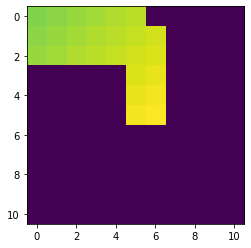

In [26]:
handle = np.random.randint(env.number_of_agents)
plt.imshow(s_graph[handle][0][:, feat_order['dist_min_to_target']].reshape((2*RAD+1, 2*RAD+1)))

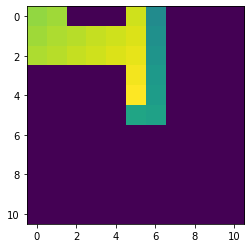

In [24]:
handle = np.random.randint(env.number_of_agents)
plt.imshow(s_graph[handle][0][:, feat_order['dist_min_to_target']].reshape((2*RAD+1, 2*RAD+1)))

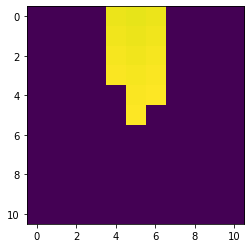

In [33]:
handle = np.random.randint(env.number_of_agents)
plt.imshow(s_graph[handle][0][:, feat_order['dist_min_to_target']].reshape((2*RAD+1, 2*RAD+1)))

In [34]:
len(simulation_replay_buffer)

5254

In [35]:
learning_rate = 1e-4
optimizer = torch.optim.Adam(list(gcn.parameters()) + list(attention_layer.parameters()) + list(value_net.parameters()), lr=learning_rate)


### 1 Training Iteration

In [36]:
start = time.time()
for itrn in range(1000):
    
    # sampling batch of experiences
    batch_size = 32
    batch_exp = np.random.choice(list(simulation_replay_buffer.keys()), batch_size)
    for exp in batch_exp:
        simulation_replay_buffer[exp]
    try:
        # batches
        batch_nghbrs = []
        batch_nghbrs_dc = dict()
        for exp in batch_exp:
            nghbrs = simulation_replay_buffer[exp][-2]
            batch_nghbrs_dc[exp] = nghbrs
            if nghbrs is not None:
                batch_nghbrs += nghbrs
        for nghbr_exp in batch_nghbrs:
            simulation_replay_buffer[nghbr_exp]
    except KeyError:
        continue

    # groups
    batch_groups = []
    batch_groups_dc = dict()
    for exp in batch_exp:
        group = simulation_replay_buffer[exp][-1]
        batch_groups_dc[exp] = group
        if group is not None:
            batch_groups += group
    for group_exp in batch_groups:
        simulation_replay_buffer[group_exp]

    # Build Neighbor tensors and Pass neighbors through GCN without autograd

    if batch_nghbrs:
        (nghbr_p_feats, nghbr_p_supps), (nghbr_s_feats, nghbr_s_supps) = build_train_tensors(batch_nghbrs)
        nghbr_p_feats, nghbr_p_supps = nghbr_p_feats.to(device), nghbr_p_supps.to(device)
    
        gcn.eval()
        with torch.no_grad():
            nghbr_p_gcn_outs = gcn((nghbr_p_feats, nghbr_p_supps))
            
        nghbr_p_gcn_central_outs = get_central_tens(nghbr_p_gcn_outs[0], len(batch_nghbrs))
    
    # Build Agent tensors and Pass agents through GCN with autograd
    (p_feats, p_supps), (s_feats, s_supps) = build_train_tensors(batch_exp, batch_size)
    p_feats, p_supps = p_feats.to(device), p_supps.to(device)

    gcn.train()
    p_gcn_outs = gcn((p_feats, p_supps))

    p_gcn_central_outs = get_central_tens(p_gcn_outs[0], batch_size)

    # Pass through Attention Layer and Value Network
    v_net_input = torch.zeros((batch_size, 1, 2*args['hidden'])).float().to(device)
    for k, exp in enumerate(batch_exp):
        nghbrs_idx = None
        is_dummy = True
        nghbrs = batch_nghbrs_dc[exp]
        if nghbrs is not None:
            nghbrs_idx = [batch_nghbrs.index(nghbr) for nghbr in nghbrs]
        if nghbrs_idx is not None:
            idx_nghbr_p_gcn_central_outs = nghbr_p_gcn_central_outs[nghbrs_idx].reshape((1, len(nghbrs_idx), args['hidden']))
            is_dummy = False
        else:
            dummy_tens = torch.zeros((1, 1, args['hidden'])).float().to(device).detach()

        if not is_dummy:
            idx_p_att_central_outs = attention_layer(p_gcn_central_outs[k].reshape((1, 1, args['hidden'])),
                                                     idx_nghbr_p_gcn_central_outs, 
                                                     idx_nghbr_p_gcn_central_outs)
    
            idx_p_conc_central_outs = torch.cat((p_gcn_central_outs[k].reshape((1, 1, args['hidden'])), 
                                                 idx_p_att_central_outs), -1)

        else:
            idx_p_conc_central_outs = torch.cat((p_gcn_central_outs[k].reshape((1, 1, args['hidden'])), dummy_tens), -1)
    
        v_net_input[k] = idx_p_conc_central_outs.reshape((1, 2*args['hidden']))
    
    value_net.train()
    value_tens = value_net(v_net_input)

    batch_rewards = get_batch_rewards(batch_exp, batch_size)

    loss = (((value_tens-batch_rewards)**2).sum())/2
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

end = time.time()
print('{} second runtime'.format(round(end-start, 6)))


431.564655 second runtime


In [37]:
torch.cuda.memory_allocated(), torch.cuda.memory_cached()

(10331648, 75497472)

### Randomly sampled batch rewards are too sparse, sample "interesting" experiences only, defined by agent proximity to other agents or multi-directional switches